# What's the Most Consistent Happy Country?
## Summer 2024 Data Science Project

**By Matvey Lyapin.**

### Introduction

Some parts of the world contain people that are generally happy, and other parts of the world contain people that are generally not so happy. Unfortunately, this is currently the state of human affairs. Fortunately, there are some meaningful questions we can ask about this state of human affairs; questions that, if answered, can help anyone -- from world leaders to next-door neighbors -- make informed decisions to manifest a better world. Which regions of the world are happiest? Which large-scale factors correlate with a region's happiness? Are differences in happiness between countries even that large? And -- most importantly for our purposes -- can it be predicted? In this tutorial, we will demonstrate the ebbs and flows of the data science lifecycle by taking a statistical approach to these tough questions, with a little help from the [World Happiness Report](https://worldhappiness.report/).

### Data Curation

Data Sources:
1. World Happiness Report 2024 (Two Datasets)
   - Helliwell, J. F., Layard, R., Sachs, J. D., De Neve, J.-E., Aknin, L. B., & Wang, S. (Eds.), Data for Table 2.1. (2024). *World Happiness Report 2024* \[Data File]. Retrieved from https://worldhappiness.report/ed/2024/#appendices-and-data:~:text=for%20Figure%202.1-,Data%20for%20Table%202.1,-Chapter%203%20Appendix.
   - Helliwell, J. F., Layard, R., Sachs, J. D., De Neve, J.-E., Aknin, L. B., & Wang, S. (Eds.), Data for Figure 2.1. (2024). *World Happiness Report 2024* \[Data File]. Retrieved from https://worldhappiness.report/ed/2024/#appendices-and-data:~:text=for%20Chapter%202-,Data%20for%20Figure%202.1,-Data%20for%20Table.


First, let's import all the python libraries that we're going to need for this tutorial.
- I'm doing this in one cell up-front since I know which ones I need ahead of time, but in a realistic situation you'd usually add them as you go along and as you gradually figure out what functionality you require. 
- In fact, that last point really goes for most of this tutorial. Just because I'm feeding you code in perfect atomic sequential little blocks doesn't mean that it was actually *written* that way, or that it "should be" written that way; quite the contrary! Always remember that code is almost *never* written sequentially!

In [176]:
## Import important stuff.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator # for plots in Visualization
from sklearn.linear_model import LinearRegression # for Primary Analysis
from sklearn.metrics import mean_absolute_error, r2_score # for Primary Analysis

Let's now import the World Happiness Report Excel sheet into a dataframe, and have a look at it.

In [177]:
xlsx = pd.ExcelFile("datasets/whr/src/WHR_Tab2.1.xls") # relative path to data
whole_whr = pd.read_excel(xlsx, "Sheet1") # yoink Sheet1 of Excel Spreadsheet
print(whole_whr.head().to_string())

  Country name  year  Life Ladder  Log GDP per capita  Social support  Healthy life expectancy at birth  Freedom to make life choices  Generosity  Perceptions of corruption  Positive affect  Negative affect
0  Afghanistan  2008     3.723590            7.350416        0.450662                         50.500000                      0.718114    0.164055                   0.881686         0.414297         0.258195
1  Afghanistan  2009     4.401778            7.508646        0.552308                         50.799999                      0.678896    0.187297                   0.850035         0.481421         0.237092
2  Afghanistan  2010     4.758381            7.613900        0.539075                         51.099998                      0.600127    0.117861                   0.706766         0.516907         0.275324
3  Afghanistan  2011     3.831719            7.581259        0.521104                         51.400002                      0.495901    0.160098                   0.731109

That third column you see, titled 'Life Ladder', is what we're interested in. Think of it as the average "happiness" of a nationally representative sample -- ranging from 1 to 10 -- from a given country. This metric is sometimes called the Cantril Scale or the Cantril ladder.
- For more information, see:
  - [WHR FAQ](https://worldhappiness.report/faq/#:~:text=What%20is%20the%20original%20source%20of%20the%20data%20for%20Figure%202.1%3F%20How%20are%20the%20rankings%20calculated%3F)
  - [Gallup: Understanding How Gallup Uses the Cantril Scale](https://news.gallup.com/poll/122453/understanding-gallup-uses-cantril-scale.aspx)

Now, since we don't really care about anything other than the 'Country name', 'year', and 'Life Ladder' columns, we're gonna drop them.

In [178]:
whr = whole_whr[['Country name', 'year', 'Life Ladder']]
print(whr)

     Country name  year  Life Ladder
0     Afghanistan  2008     3.723590
1     Afghanistan  2009     4.401778
2     Afghanistan  2010     4.758381
3     Afghanistan  2011     3.831719
4     Afghanistan  2012     3.782938
...           ...   ...          ...
2358     Zimbabwe  2019     2.693523
2359     Zimbabwe  2020     3.159802
2360     Zimbabwe  2021     3.154578
2361     Zimbabwe  2022     3.296220
2362     Zimbabwe  2023     3.572386

[2363 rows x 3 columns]


But there's also another issue: the years on this table only go up to 2023! Since the data for 2024 is in a separate dataset, we're going to need to perform some trickery to get all the parts we need in one place.

So, to make things easier for us donw the line, let's pivot the table around...

In [179]:
ll = whr.pivot(index='Country name', columns='year', values='Life Ladder')
print(ll.head().to_string())

year          2005      2006      2007      2008      2009      2010      2011      2012      2013      2014      2015      2016      2017      2018      2019      2020      2021      2022      2023
Country name                                                                                                                                                                                          
Afghanistan    NaN       NaN       NaN  3.723590  4.401778  4.758381  3.831719  3.782938  3.572100  3.130896  3.982855  4.220169  2.661718  2.694303  2.375092       NaN  2.436034  1.281271  1.445909
Albania        NaN       NaN  4.634252       NaN  5.485470  5.268937  5.867422  5.510124  4.550648  4.813763  4.606651  4.511101  4.639548  5.004403  4.995318  5.364910  5.255482  5.212213  5.444691
Algeria        NaN       NaN       NaN       NaN       NaN  5.463567  5.317194  5.604596       NaN  6.354898       NaN  5.340854  5.248912  5.043086  4.744627  5.437755  5.217018  5.538172       NaN
Angol

Import the 2024 data...

In [180]:
xlsx = pd.ExcelFile("datasets/whr/src/WHR_Fig2.1.xls")
whr_2024 = pd.read_excel(xlsx, "Sheet1")[['Country name', 'Ladder score']].set_index('Country name').rename(columns={'Ladder score': 2024})
print(whr_2024)

                    2024
Country name            
Finland           7.7407
Denmark           7.5827
Iceland           7.5251
Sweden            7.3441
Israel            7.3411
...                  ...
Congo (Kinshasa)  3.2954
Sierra Leone      3.2452
Lesotho           3.1862
Lebanon           2.7065
Afghanistan       1.7210

[143 rows x 1 columns]


And then join our two DataFrames.

In [181]:
ll = ll.join(whr_2024)
print(ll.head().to_string())

              2005      2006      2007      2008      2009      2010      2011      2012      2013      2014      2015      2016      2017      2018      2019      2020      2021      2022      2023    2024
Country name                                                                                                                                                                                                  
Afghanistan    NaN       NaN       NaN  3.723590  4.401778  4.758381  3.831719  3.782938  3.572100  3.130896  3.982855  4.220169  2.661718  2.694303  2.375092       NaN  2.436034  1.281271  1.445909  1.7210
Albania        NaN       NaN  4.634252       NaN  5.485470  5.268937  5.867422  5.510124  4.550648  4.813763  4.606651  4.511101  4.639548  5.004403  4.995318  5.364910  5.255482  5.212213  5.444691  5.3042
Algeria        NaN       NaN       NaN       NaN       NaN  5.463567  5.317194  5.604596       NaN  6.354898       NaN  5.340854  5.248912  5.043086  4.744627  5.437755  5.

Beautiful.

### Exploratory Data Analysis

### Primary Analysis

Now that we've gotten a feel for the data, let's try building a model that takes in a country and predicts its future Life Ladder score. We start by writing a (relatively) small class that takes in a country from our dataset along with a year up to which we want to train it, and fits a Simple Linear Regression (SLR) to the relevant data.

In [182]:
class HapModel:
    def __init__(self, country, train_upto=2023):
        self.name = country

        # Form training and testing datasets of independent (X) and dependent (y) variables.
        country_loc = ll.loc[country].dropna()
        country_loc.index = country_loc.index.astype(int)
        self.X_train = country_loc.index[country_loc.index <= train_upto].to_numpy().reshape(-1, 1)
        self.y_train = country_loc[country_loc.index <= train_upto].to_numpy().reshape(-1, 1)
        self.X_test = country_loc.index[country_loc.index > train_upto].to_numpy().reshape(-1, 1)
        self.y_test = country_loc[country_loc.index > train_upto].to_numpy().reshape(-1, 1)

        # Fit SLR to our training dataset.
        self.model = LinearRegression().fit(self.X_train, self.y_train)

        # Form an array of predictions for all values in X.
        self.y_train_pred = self.model.predict(self.X_train)
        self.y_test_pred = self.model.predict(self.X_test) if self.X_test.size else None # Account for the case where there's no test data!

        # Join tests and trains together for later plotting convenience
        self.X_whole = np.concatenate((self.X_train, self.X_test))
        self.y_whole = np.concatenate((self.y_train, self.y_test))
        self.y_pred_whole = np.concatenate((self.y_train_pred, self.y_test_pred)) if self.y_test_pred is not None else self.y_train_pred

        # Compute the coefficient of determination for our model.
        self.r2 = r2_score(self.y_whole, self.y_pred_whole)

        self.test_mae = mean_absolute_error(self.y_test, self.y_test_pred) if self.y_test.size else None # Account for the case where there's no test data!

    def transform_axes(self, axes):
        """Take matplotlib axis and impress the HapModel's regression plot upon it."""
        
        # Add train and test data points.
        axes.scatter(self.X_train, self.y_train, color='blue', label='Train Data')
        axes.scatter(self.X_test, self.y_test, color='orange', label='Test Data')

        # Add SLR line.
        axes.plot(self.X_whole, self.y_pred_whole, color='red', label='Linear Regression')

        # Make sure the x axis shows only round numbers.
        axes.xaxis.set_major_locator(MaxNLocator(integer=True))

        # Show title with R2 displayed to 7 decimal places.
        axes.set_title(f'{self.name}\'s Life Ladder Over Time (R2={"{:.7f}".format(self.r2)})')

        axes.set_ylabel('Life Ladder Score')
        axes.set_xlabel('Year')

        # Add little box in the top right showing what stuff is.
        axes.legend()

    def report(self):
        """Displays the HapModel's regression plot."""
        fig, axes = plt.subplots()
        self.transform_axes(axes)
        plt.show()
    
    def predict_happiness(self, year):
        """Returns the HapModel's predicted Life Ladder score for the provided year."""
        return self.model.predict([[year]]).clip(min=0)[0][0]

    def display_happy_pred(self, year):
        """Prints the HapModel's predicted Life Ladder score for the provided year and the year's true value (if applicable) with a little message."""
        but = f', but its true value is {self.y_test[0][np.nonzero(self.X_test == year)[1][0]]}' if year in self.X_test else ''
        print(f'In {year}, {self.name}\'s Life Ladder score is projected to be {self.predict_happiness(year)}' + but + '!')

Just looking at that makes me tired. Whew.
- For more on Simple Linear Regression, see:
  - [PennState, STAT501, Lesson 1: Simple Linear Regression](https://online.stat.psu.edu/stat501/lesson/1)
  - [Wikipedia - Simple linear regression](https://en.wikipedia.org/wiki/Simple_linear_regression)

In [183]:
def get_prediction_table(year, train_upto=2023):
    """Generate DataFrame containing the most important metrics of each country's HapModel."""
    slindex = ll.dropna(subset=range(train_upto-2, train_upto+1)).index.to_numpy()
    d = {
        'Country name': slindex,
        f'Predicted Life Ladder in {year}': (np.vectorize(lambda x: HapModel(x, train_upto).predict_happiness(year)))(slindex),
        'Total R2': (np.vectorize(lambda x: HapModel(x, train_upto).r2))(slindex),
        'Mean Absolute Test Error': (np.vectorize(lambda x: HapModel(x, train_upto).test_mae))(slindex),
        'Data Points Used': (np.vectorize(lambda x: HapModel(x, train_upto).X_train.size))(slindex)
        }

    result = pd.DataFrame(d).sort_values(by=[f'Predicted Life Ladder in {year}'], ascending=False).reset_index(drop=True)
    result.index += 1
    return result

year_of_interest = 2024
pt = get_prediction_table(year_of_interest)

In [184]:
print(pt.head(10).to_string())

   Country name  Predicted Life Ladder in 2024  Total R2  Mean Absolute Test Error  Data Points Used
1       Finland                       7.804743  0.333004                  0.064043                16
2       Iceland                       7.653391  0.343877                  0.128291                11
3       Denmark                       7.468295  0.467467                  0.114405                18
4   Netherlands                       7.352183  0.332033                  0.032784                17
5        Norway                       7.331114  0.441024                  0.029414                13
6        Sweden                       7.329573  0.037573                  0.014527                18
7        Israel                       7.283674  0.018559                  0.057426                18
8   Switzerland                       7.224359  0.377685                  0.164159                13
9   New Zealand                       7.090144  0.486723                  0.060943         

In [185]:
print(pt.tail(10).to_string())

     Country name  Predicted Life Ladder in 2024  Total R2  Mean Absolute Test Error  Data Points Used
108        Jordan                       4.026435  0.786079                  0.159365                18
109         Egypt                       3.836332  0.456134                  0.140268                18
110  Sierra Leone                       3.776586  0.044073                  0.531386                15
111         India                       3.644800  0.566366                  0.409300                18
112        Zambia                       3.634843  0.451006                  0.132444                17
113      Tanzania                       3.513290  0.057735                  0.267310                18
114      Zimbabwe                       3.296185  0.201868                  0.044915                18
115       Lebanon                       3.225049  0.508241                  0.518549                18
116        Malawi                       3.210499  0.533924               

In [186]:
len(pt)

117

In [187]:
tpt = pt[pt['Total R2'] >= 0.5]

In [188]:
print(tpt.head(10).to_string())

                Country name  Predicted Life Ladder in 2024  Total R2  Mean Absolute Test Error  Data Points Used
10                 Australia                       7.086516  0.635108                  0.029616                17
13                   Czechia                       6.945755  0.576192                  0.123955                15
14                    Canada                       6.933005  0.764286                  0.033405                18
18                   Belgium                       6.783671  0.535562                  0.110529                17
19                   Uruguay                       6.740085  0.539725                  0.128586                18
20                 Lithuania                       6.715224  0.669597                  0.102276                18
21                  Slovenia                       6.709908  0.699031                  0.033392                16
22                   Romania                       6.705902  0.805680                  0

In [189]:
print(tpt.tail(10).to_string())

    Country name  Predicted Life Ladder in 2024  Total R2  Mean Absolute Test Error  Data Points Used
79         Gabon                       5.370827  0.762377                  0.264527                13
80       Armenia                       5.338066  0.550962                  0.116834                17
81       Georgia                       5.295706  0.908136                  0.111006                18
82      Cameroon                       5.193722  0.520808                  0.319322                18
101         Togo                       4.489402  0.700500                  0.275302                12
108       Jordan                       4.026435  0.786079                  0.159365                18
111        India                       3.644800  0.566366                  0.409300                18
115      Lebanon                       3.225049  0.508241                  0.518549                18
116       Malawi                       3.210499  0.533924                  0.21050

In [190]:
len(tpt)

42

In [191]:
rpt = pt.sort_values(by=['Total R2'], ascending= False)

In [192]:
print(rpt.head(10).to_string())

               Country name  Predicted Life Ladder in 2024  Total R2  Mean Absolute Test Error  Data Points Used
81                  Georgia                       5.295706  0.908136                  0.111006                18
68                 Bulgaria                       5.820788  0.899165                  0.358089                15
27                   Serbia                       6.640583  0.892282                  0.229783                16
30                   Latvia                       6.545031  0.873387                  0.310531                17
33                  Estonia                       6.499739  0.852380                  0.052039                17
59                 Mongolia                       5.927778  0.848940                  0.231578                16
22                  Romania                       6.705902  0.805680                  0.214702                17
108                  Jordan                       4.026435  0.786079                  0.159365  

In [193]:
print(rpt.tail(10).to_string())

    Country name  Predicted Life Ladder in 2024  Total R2  Mean Absolute Test Error  Data Points Used
7         Israel                       7.283674  0.018559                  0.057426                18
39     Singapore                       6.440379  0.016645                  0.082421                16
85          Laos                       5.069226  0.016383                  0.069674                12
104      Myanmar                       4.362020  0.014632                  0.007520                12
83       Albania                       5.107181  0.006604                  0.197020                16
88       Nigeria                       5.044738  0.002146                  0.163939                16
49      Thailand                       6.120159  0.000681                  0.144059                18
66      Malaysia                       5.842682 -0.000851                  0.132518                16
96       Namibia                       4.682388 -0.002835                  0.14931

In [194]:
test_pt = pt.sort_values(by=['Mean Absolute Test Error']).dropna(subset=['Mean Absolute Test Error'])

In [195]:
print(test_pt.head(10).to_string())

           Country name  Predicted Life Ladder in 2024  Total R2  Mean Absolute Test Error  Data Points Used
52             Portugal                       6.023615  0.505533                  0.005985                16
104             Myanmar                       4.362020  0.014632                  0.007520                12
16              Ireland                       6.847289  0.298669                  0.009289                17
50          South Korea                       6.069125  0.083731                  0.011225                18
54             Paraguay                       5.988622  0.352590                  0.012122                17
6                Sweden                       7.329573  0.037573                  0.014527                18
69   Dominican Republic                       5.803234  0.516020                  0.019566                18
36          El Salvador                       6.447481  0.188427                  0.021219                18
35               Po

In [196]:
print(test_pt.tail(10).to_string())

     Country name  Predicted Life Ladder in 2024  Total R2  Mean Absolute Test Error  Data Points Used
86   South Africa                       5.054147  0.031700                  0.367853                18
78         Guinea                       5.392180  0.614529                  0.368880                13
106    Bangladesh                       4.267020  0.247222                  0.381120                18
72         Greece                       5.539186 -0.006515                  0.394414                17
111         India                       3.644800  0.566366                  0.409300                18
75    Ivory Coast                       5.510254  0.548549                  0.430154                12
92          Benin                       4.879063  0.373804                  0.501664                15
115       Lebanon                       3.225049  0.508241                  0.518549                18
110  Sierra Leone                       3.776586  0.044073               

### Visualization

In [197]:
def ploterooo(num_in_tier, df, title):
    country_list = df.head(num_in_tier)['Country name'].to_list() + df.tail(num_in_tier)['Country name'].to_list()
    fig, axes = plt.subplots(figsize=(10, 15))
    cmap = plt.get_cmap('rainbow', num_in_tier*2)

    for i in range(num_in_tier*2):
        hap = HapModel(country_list[i])
        axes.scatter(hap.X_whole, hap.y_whole, color=cmap(i), label=country_list[i], alpha=0.5)
        axes.plot(hap.X_whole, hap.y_pred_whole, color=cmap(i))
    axes.xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.xticks(np.arange(2006, 2025, 2.0))
    axes.set_ylabel('Life Ladder Score')
    axes.set_xlabel('Year')
    axes.set_title(title, fontsize=10, loc='center', wrap=True)  
    axes.legend()

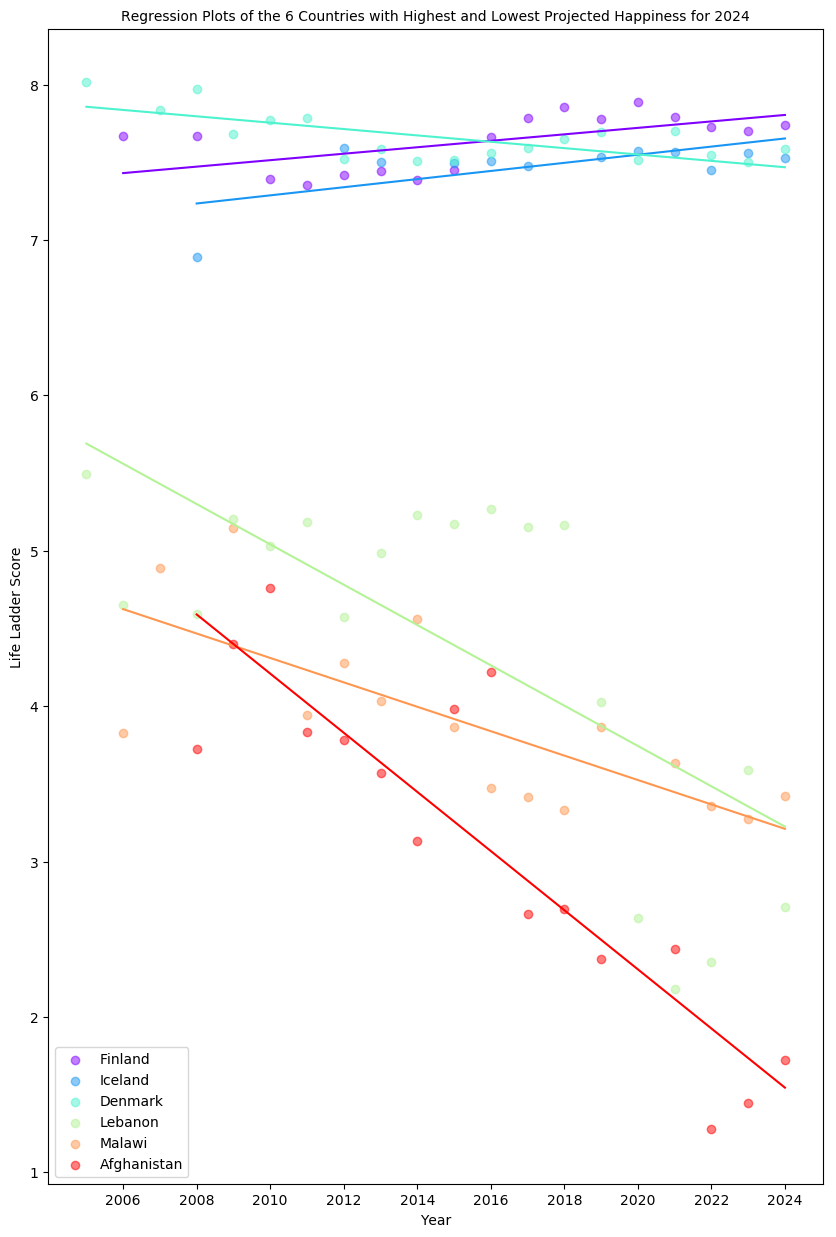

In [198]:
ploterooo(3, pt, f"Regression Plots of the 6 Countries with Highest and Lowest Projected Happiness for {year_of_interest}")

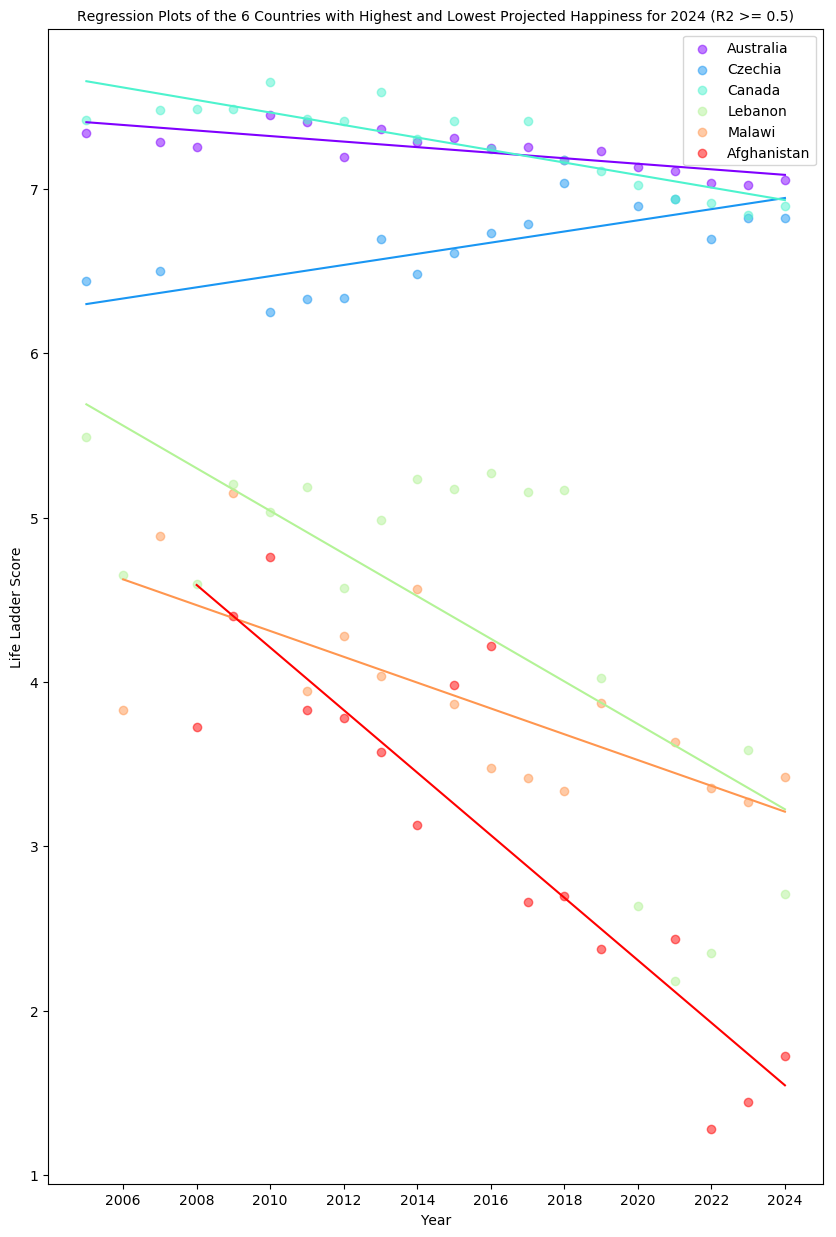

In [199]:
ploterooo(3, tpt, f"Regression Plots of the 6 Countries with Highest and Lowest Projected Happiness for {year_of_interest} (R2 >= 0.5)")

In [231]:
def ploteroo(x, y, df, title):
  country_list = df.head(x*y)['Country name'].to_list()
  fig, axes = plt.subplots(y, x, figsize=(12.5, 15))

  k = 0
  for i in range(y):
    for j in range(x):
      HapModel(country_list[k]).transform_axes(axes[i][j])
      k += 1

  fig.suptitle(title, fontsize=20)
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])
  plt.show()

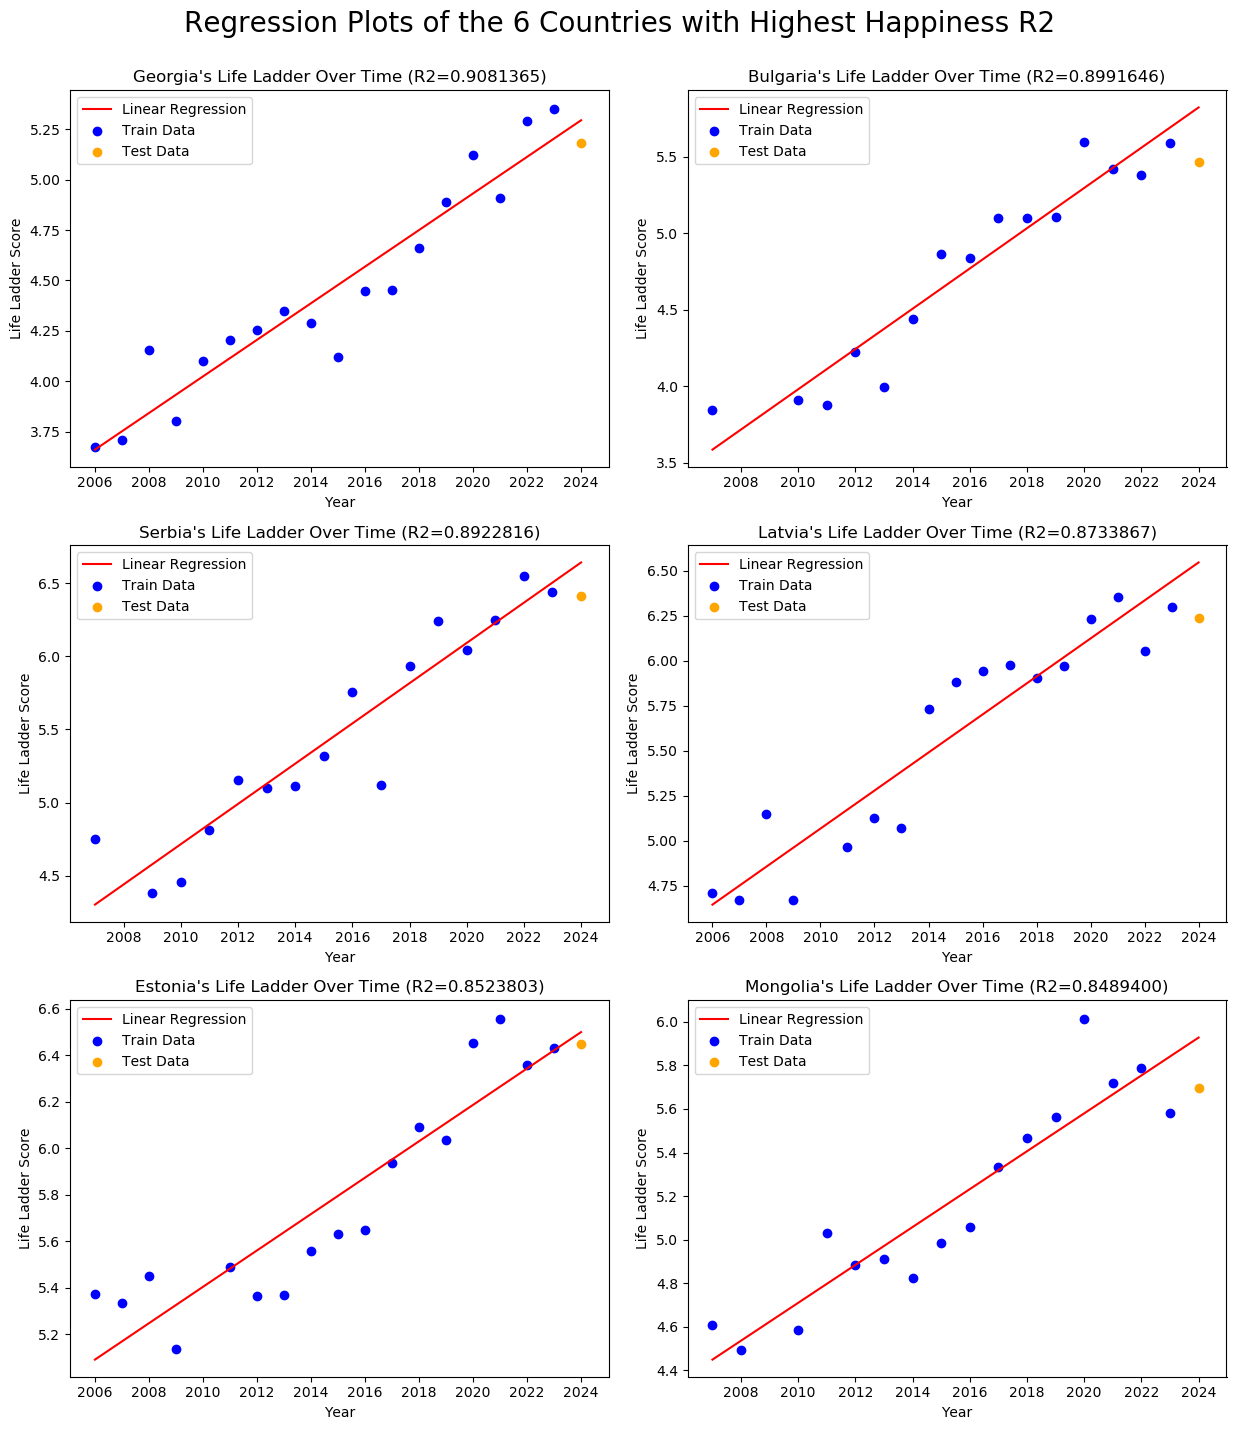

In [232]:
ploteroo(2, 3, rpt, "Regression Plots of the 6 Countries with Highest Happiness R2")

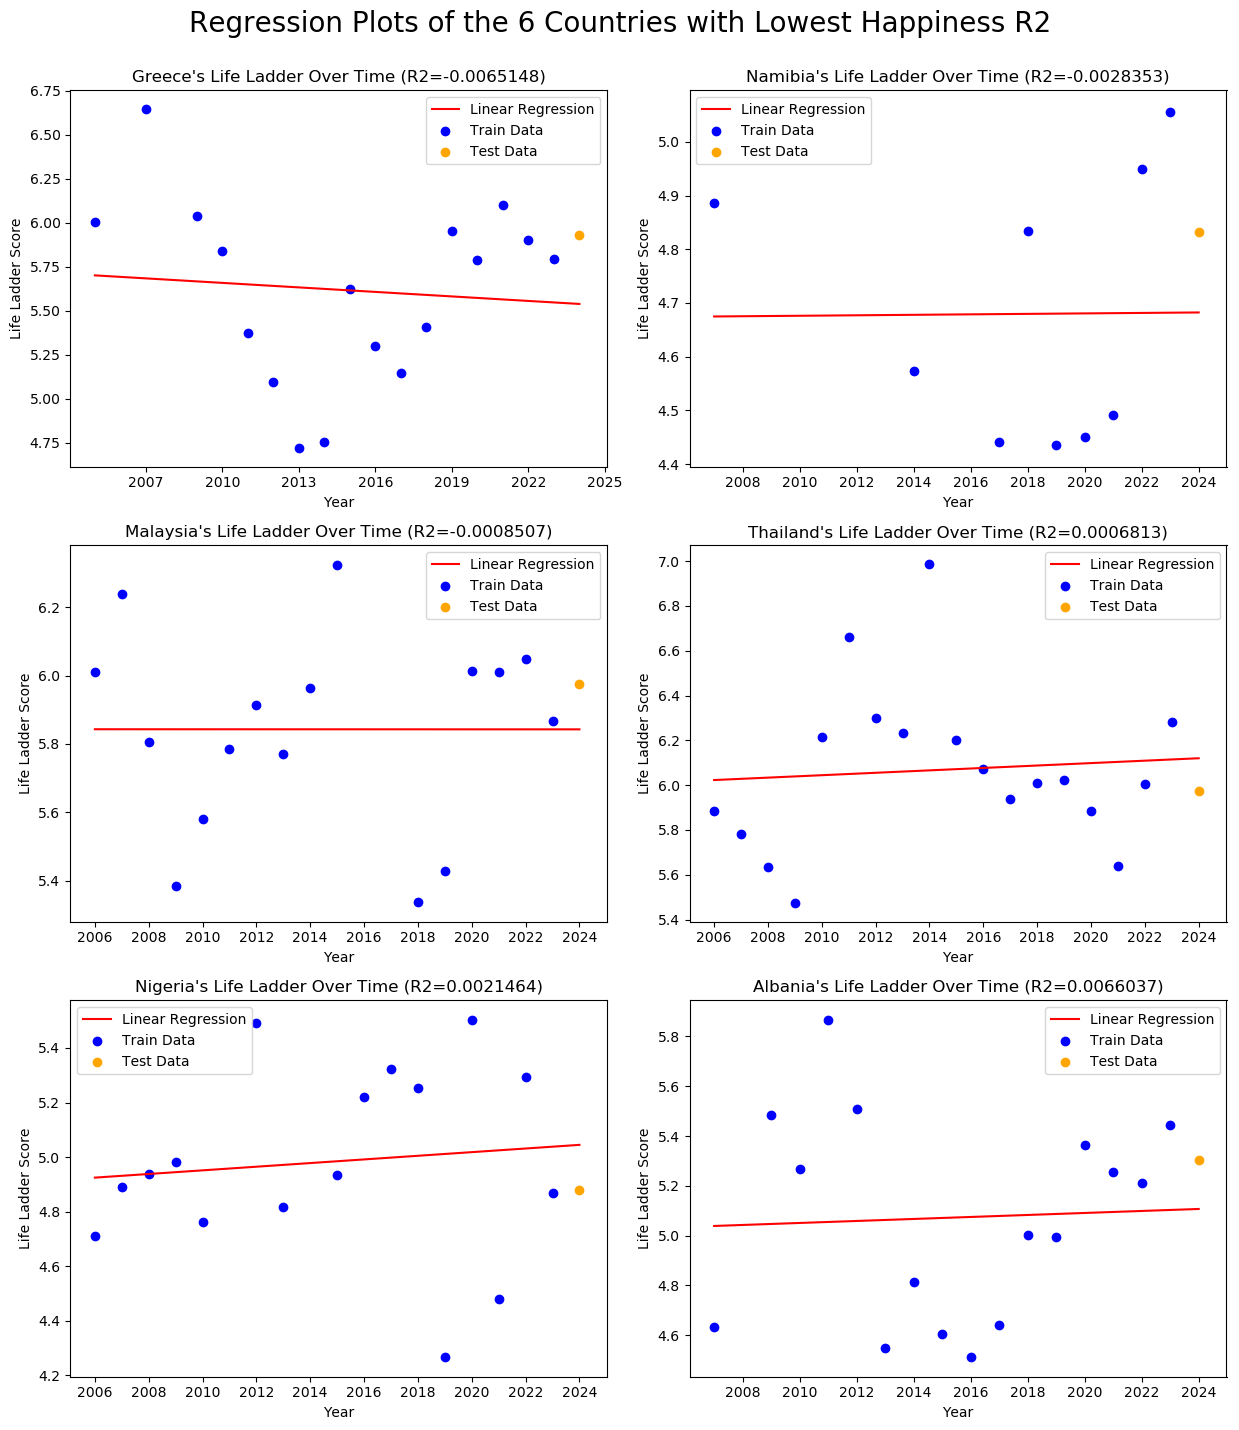

In [233]:
ploteroo(2, 3, rpt.iloc[::-1], "Regression Plots of the 6 Countries with Lowest Happiness R2")

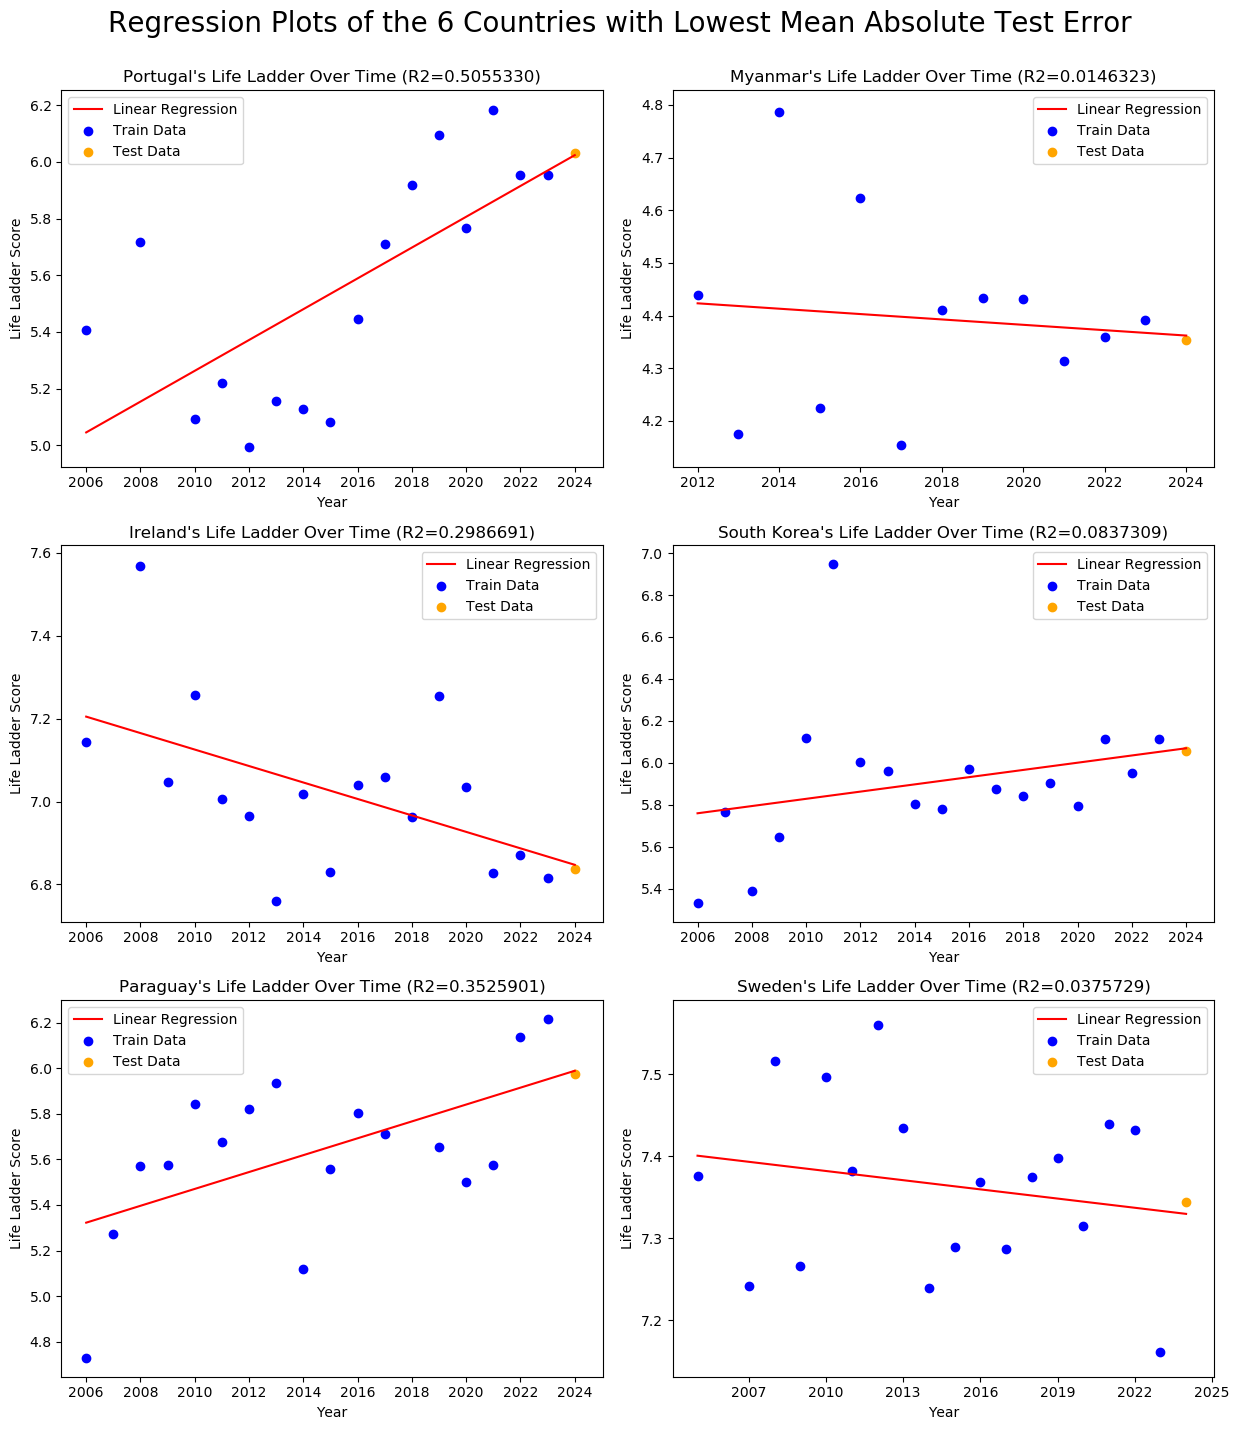

In [234]:
ploteroo(2, 3, test_pt, "Regression Plots of the 6 Countries with Lowest Mean Absolute Test Error")

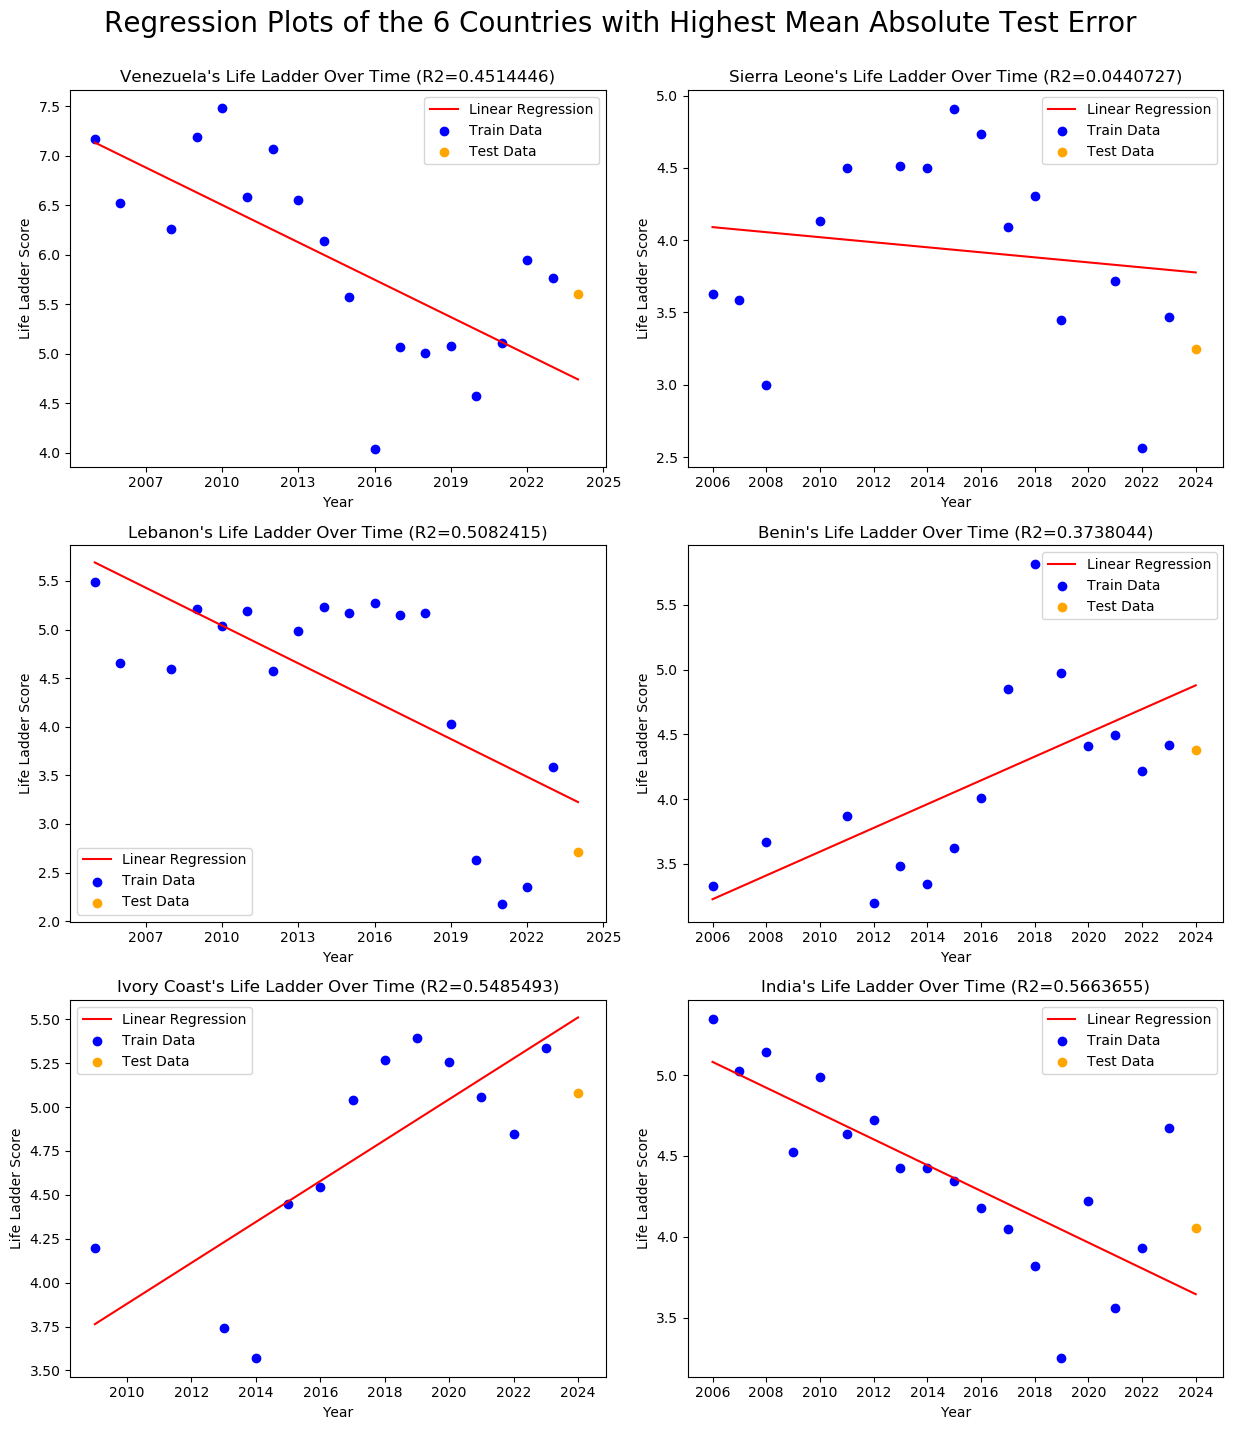

In [235]:
ploteroo(2, 3, test_pt.iloc[::-1], "Regression Plots of the 6 Countries with Highest Mean Absolute Test Error")

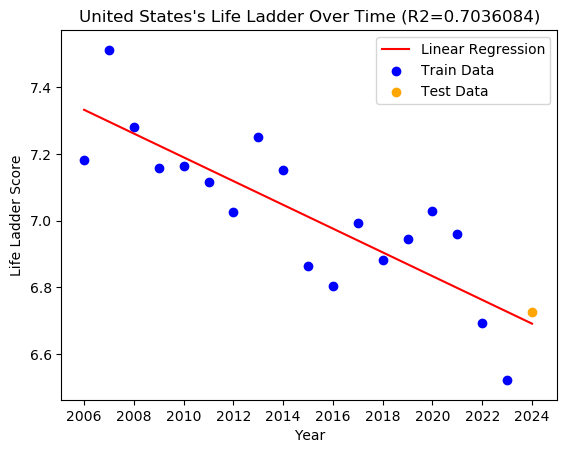

In 2024, United States's Life Ladder score is projected to be 6.690495712305207, but its true value is 6.724800109863281!


In [236]:
h1 = HapModel('United States')
h1.report()
h1.display_happy_pred(year_of_interest)

### Insights and Conclusions